https://gmarti.gitlab.io/qfin/2018/10/02/hierarchical-risk-parity-part-1.html

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
%matplotlib inline


nb_alphas = 250
nb_observations = int(0.3 * 252)

# build a hierarchical block diagonal correlation matrix
quality = 0.6 * np.ones((nb_alphas // 6, nb_alphas // 6))
value = 2.4 * np.ones((nb_alphas // 2, nb_alphas // 2))
momentum = 2.6 * np.ones((int(nb_alphas * (1 - 1/6 - 1/2) + 1),
                          int(nb_alphas * (1 - 1/6 - 1/2) + 1)))

correl_mom_value = -1.2 * np.ones((int(nb_alphas * (1 - 1/6)) + 1,
                                   int(nb_alphas * (1 - 1/6)) + 1))


correl = (block_diag(quality, correl_mom_value) +
          block_diag(quality, momentum, value)) / 3
np.fill_diagonal(correl, 1)



mean_returns = np.zeros(nb_alphas)
volatilities = ([np.sqrt(0.1 / np.sqrt(252))] * (nb_alphas // 3) + 
                [np.sqrt(0.3 / np.sqrt(252))] * (nb_alphas - nb_alphas // 3 - nb_alphas // 6) + 
                [np.sqrt(0.5 / np.sqrt(252))] * (nb_alphas // 6))
covar = np.multiply(correl,
                    np.outer(np.array(volatilities),
                             np.array(volatilities)))
covar = pd.DataFrame(covar)

In [4]:
co = pd.DataFrame(correl)
co

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,1.0,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.4,1.0,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4,0.4,1.0,0.4,0.4,0.4,0.4,0.4,0.4,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4,0.4,0.4,1.0,0.4,0.4,0.4,0.4,0.4,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4,0.4,0.4,0.4,1.0,0.4,0.4,0.4,0.4,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.4,0.4,0.4,0.4,1.0,0.4,0.4,0.4,0.4
246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.4,0.4,0.4,0.4,0.4,1.0,0.4,0.4,0.4
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,1.0,0.4,0.4
248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,1.0,0.4


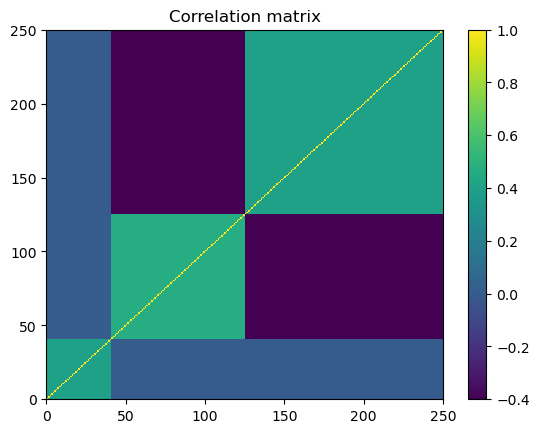

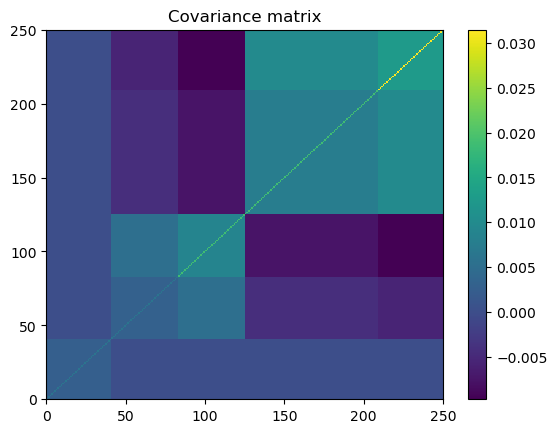

In [5]:
plt.pcolormesh(correl)
plt.colorbar()
plt.title('Correlation matrix')
plt.show()

plt.pcolormesh(covar)
plt.colorbar()
plt.title('Covariance matrix')
plt.show()

In [6]:
alphas_returns = np.random.multivariate_normal(
    mean_returns, cov=covar, size=nb_observations)

alphas_returns = pd.DataFrame(alphas_returns)

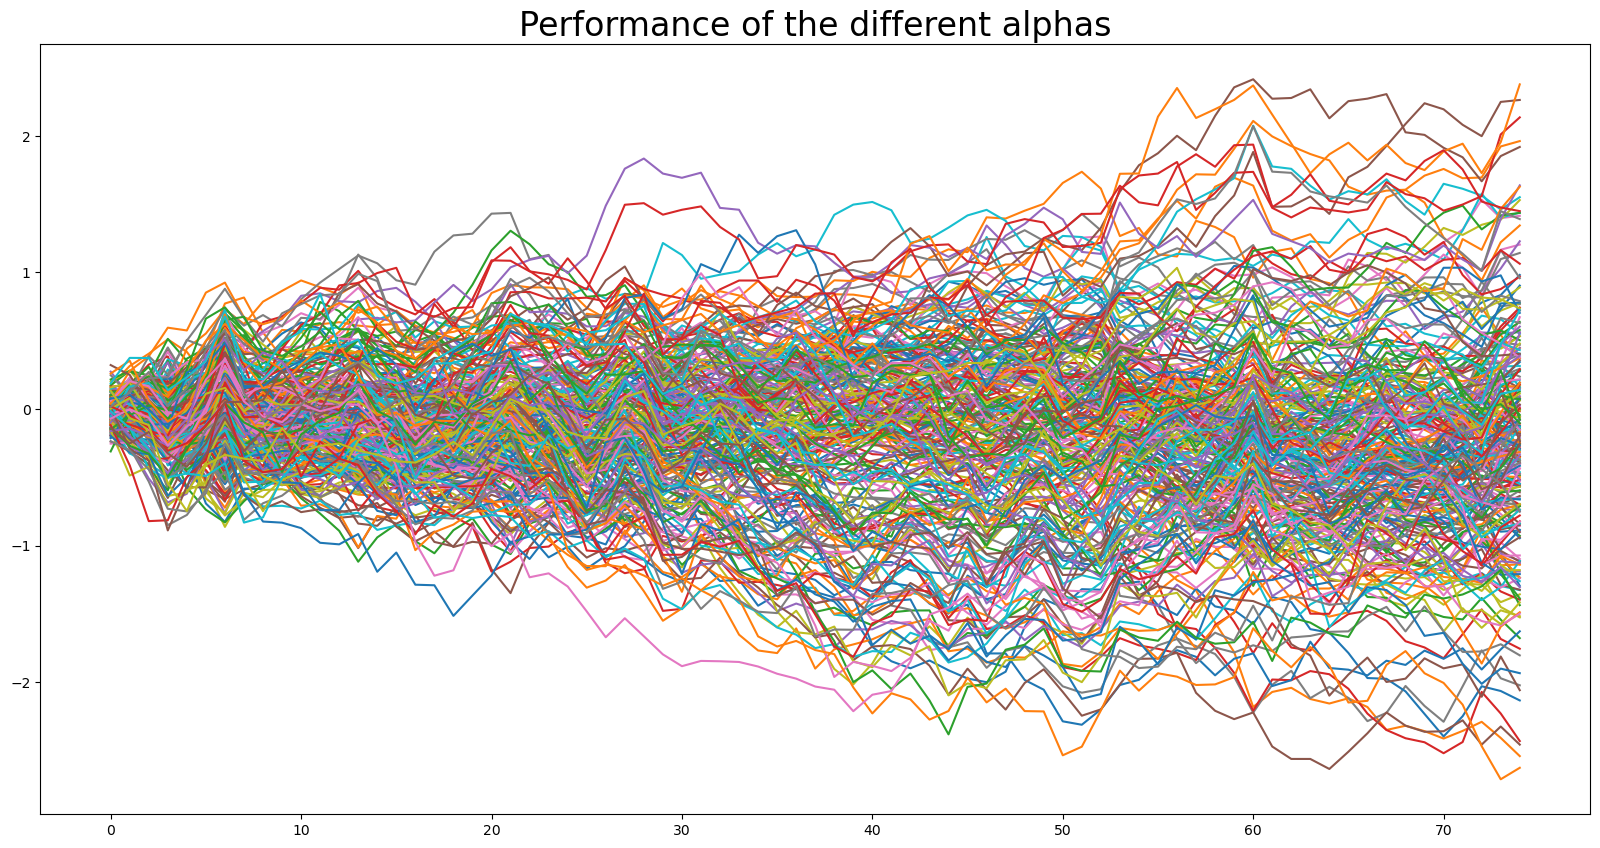

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(alphas_returns.cumsum())
plt.title('Performance of the different alphas', fontsize=24)
plt.show()

# First step is to estimate the correlation matrix

In [8]:
estimate_correl = alphas_returns.corr(method='pearson')
estimate_covar = alphas_returns.cov()

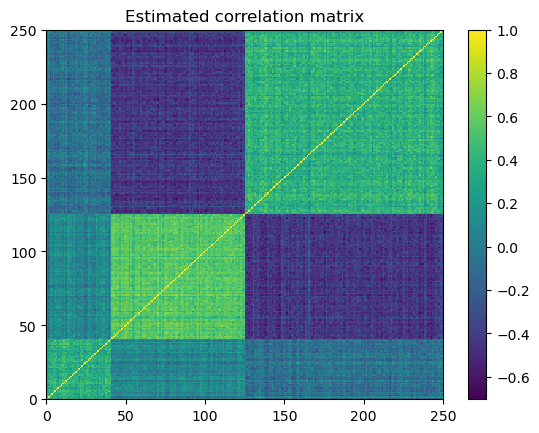

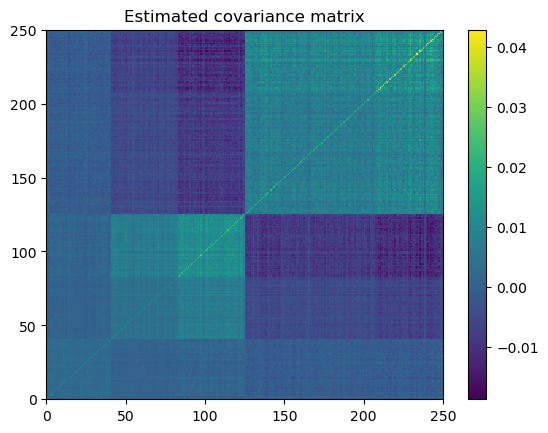

In [9]:
plt.pcolormesh(estimate_correl)
plt.colorbar()
plt.title('Estimated correlation matrix')
plt.show()

plt.pcolormesh(estimate_covar)
plt.colorbar()
plt.title('Estimated covariance matrix')
plt.show()

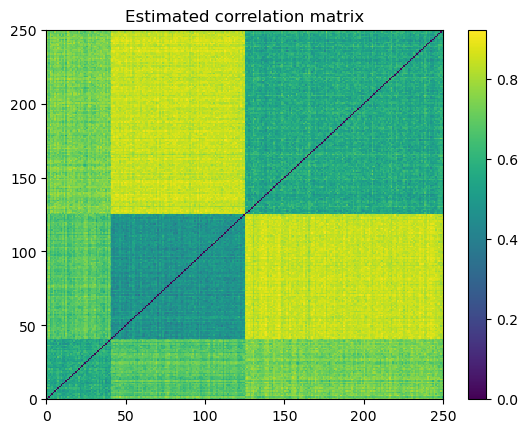

In [11]:
distances = np.sqrt((1 - estimate_correl) / 2)

plt.pcolormesh(distances)
plt.colorbar()
plt.title('Estimated correlation matrix')
plt.show()

# Second step is performing the quasi-diagonalization

In [12]:
def seriation(Z, N, cur_index):
    """Returns the order implied by a hierarchical tree (dendrogram).
    
       :param Z: A hierarchical tree (dendrogram).
       :param N: The number of points given to the clustering process.
       :param cur_index: The position in the tree for the recursive traversal.
       
       :return: The order implied by the hierarchical tree Z.
    """
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))

    
def compute_serial_matrix(dist_mat, method="ward"):
    """Returns a sorted distance matrix.
    
       :param dist_mat: A distance matrix.
       :param method: A string in ["ward", "single", "average", "complete"].
        
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    """
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a,b = np.triu_indices(N, k=1)
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [23]:
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(distances.values, method='single')
print(distances.values)

[[0.         0.58190957 0.60109985 ... 0.75382246 0.75043938 0.66641415]
 [0.58190957 0.         0.5739121  ... 0.627662   0.67128924 0.56061648]
 [0.60109985 0.5739121  0.         ... 0.76557768 0.70850364 0.71189518]
 ...
 [0.75382246 0.627662   0.76557768 ... 0.         0.56477519 0.52183586]
 [0.75043938 0.67128924 0.70850364 ... 0.56477519 0.         0.52407259]
 [0.66641415 0.56061648 0.71189518 ... 0.52183586 0.52407259 0.        ]]


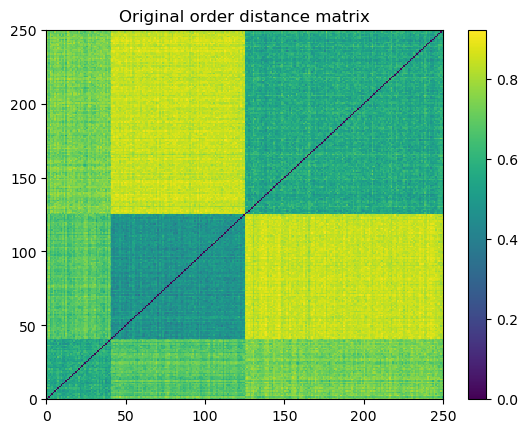

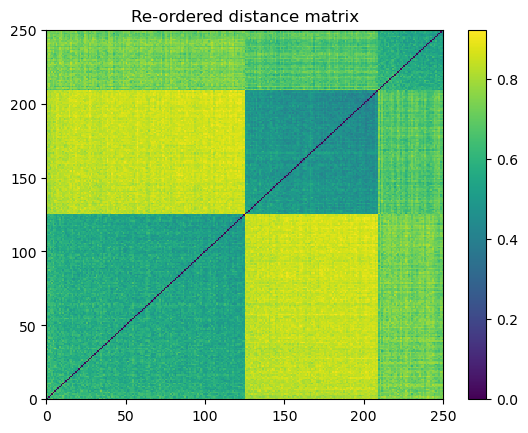

In [14]:
plt.pcolormesh(distances)
plt.colorbar()
plt.title('Original order distance matrix')
plt.show()

plt.pcolormesh(ordered_dist_mat)
plt.colorbar()
plt.title('Re-ordered distance matrix')
plt.show()

# Third step is the Lopez de Prado’s recursive bisection:

In [15]:
def compute_HRP_weights(covariances, res_order):
    weights = pd.Series(1, index=res_order)
    clustered_alphas = [res_order]

    while len(clustered_alphas) > 0:
        clustered_alphas = [cluster[start:end] for cluster in clustered_alphas
                            for start, end in ((0, len(cluster) // 2),
                                               (len(cluster) // 2, len(cluster)))
                            if len(cluster) > 1]
        for subcluster in range(0, len(clustered_alphas), 2):
            left_cluster = clustered_alphas[subcluster]
            right_cluster = clustered_alphas[subcluster + 1]

            left_subcovar = covariances[left_cluster].loc[left_cluster]
            inv_diag = 1 / np.diag(left_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

            right_subcovar = covariances[right_cluster].loc[right_cluster]
            inv_diag = 1 / np.diag(right_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

            alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)

            weights[left_cluster] *= alloc_factor
            weights[right_cluster] *= 1 - alloc_factor
            
    return weights


def compute_MV_weights(covariances):
    inv_covar = np.linalg.inv(covariances)
    u = np.ones(len(covariances))
    
    return np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))


def compute_RP_weights(covariances):
    weights = (1 / np.diag(covariances)) 
    
    return weights / sum(weights)


def compute_unif_weights(covariances):
    
    return [1 / len(covariances) for i in range(len(covariances))]

# Let’s look at the volatility of the portfolio in-sample

In [24]:
estimate_covar

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.005782,0.001793,0.001581,0.002560,0.001840,0.002187,0.002546,0.000201,0.002399,0.001358,...,-0.002833,-0.000098,-0.001947,-0.000404,-0.002693,-0.000831,-0.001279,-0.001886,-0.001590,0.001417
1,0.001793,0.005336,0.001869,0.002313,0.001515,0.002056,0.002212,0.001086,0.002667,0.001159,...,0.001606,0.001231,0.000967,0.002358,0.000367,0.000531,0.001636,0.002815,0.001194,0.004524
2,0.001581,0.001869,0.005623,0.002745,0.002260,0.001935,0.001917,0.001796,0.002842,0.002557,...,-0.003844,-0.002183,-0.002283,-0.000948,-0.002494,-0.002637,-0.002702,-0.002347,-0.000049,-0.000170
3,0.002560,0.002313,0.002745,0.008091,0.002490,0.002166,0.002662,0.001528,0.001964,0.002399,...,-0.001722,0.001589,-0.001685,-0.000043,-0.002467,0.002270,-0.001840,-0.000052,0.000244,-0.000369
4,0.001840,0.001515,0.002260,0.002490,0.006062,0.002221,0.002695,0.002105,0.002894,0.002399,...,-0.001791,-0.000396,-0.002469,-0.000497,-0.002343,-0.001985,-0.000606,0.000487,0.002223,0.001260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.000831,0.000531,-0.002637,0.002270,-0.001985,-0.001245,-0.000232,-0.001464,-0.001432,0.001760,...,0.015792,0.012855,0.012220,0.013066,0.013869,0.035300,0.010475,0.008322,0.009219,0.007439
246,-0.001279,0.001636,-0.002702,-0.001840,-0.000606,-0.000241,-0.000061,-0.002188,0.002174,-0.002467,...,0.016410,0.013245,0.017481,0.017645,0.012412,0.010475,0.031117,0.013363,0.008781,0.013417
247,-0.001886,0.002815,-0.002347,-0.000052,0.000487,0.000301,0.000873,-0.000153,0.001124,0.000122,...,0.014185,0.011300,0.013710,0.014770,0.007911,0.008322,0.013363,0.033029,0.010894,0.013801
248,-0.001590,0.001194,-0.000049,0.000244,0.002223,-0.002853,0.000888,-0.000562,-0.000587,-0.000393,...,0.011324,0.007357,0.009739,0.014438,0.011944,0.009219,0.008781,0.010894,0.027410,0.012443


In [21]:
HRP_weights = compute_HRP_weights(estimate_covar, res_order)

/var/folders/ll/8c867qfj6_50slcd4256vv3c0000gn/T/ipykernel_80806/967693519.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019
 0.23541019 0.23541019 0.23541019 0.23541019 0.23541019 0.23541

In [17]:
HRP_weights = compute_HRP_weights(covar, res_order)

print(round((HRP_weights * alphas_returns).sum(axis=1).std() * np.sqrt(252),
            2))

/var/folders/ll/8c867qfj6_50slcd4256vv3c0000gn/T/ipykernel_80806/967693519.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742
 0.17608742 0.17608742 0.17608742 0.17608742 0.17608742 0.17608

0.45


In [20]:
print(HRP_weights)
print(len(res_order), res_order)

205    0.002416
130    0.001726
165    0.001726
238    0.000960
217    0.000960
         ...   
19     0.008066
10     0.008066
12     0.008066
8      0.008066
37     0.008066
Length: 250, dtype: float64
250 [205, 130, 165, 238, 217, 248, 241, 184, 148, 169, 220, 163, 212, 133, 213, 216, 193, 174, 202, 180, 247, 239, 164, 197, 200, 157, 249, 211, 201, 189, 150, 186, 158, 152, 176, 132, 154, 149, 153, 143, 161, 126, 178, 231, 166, 125, 209, 179, 155, 172, 185, 206, 233, 234, 183, 245, 218, 146, 226, 195, 160, 188, 192, 196, 225, 219, 214, 136, 190, 207, 140, 215, 230, 187, 194, 244, 141, 223, 139, 199, 204, 191, 128, 162, 142, 167, 221, 222, 137, 210, 134, 159, 208, 227, 246, 131, 232, 224, 170, 181, 127, 171, 173, 236, 240, 182, 144, 147, 229, 135, 198, 237, 129, 177, 168, 138, 203, 156, 243, 242, 151, 175, 235, 145, 228, 46, 55, 123, 73, 63, 52, 92, 54, 119, 69, 71, 106, 98, 62, 83, 90, 59, 93, 120, 77, 121, 111, 89, 84, 109, 86, 122, 64, 104, 113, 117, 66, 116, 124, 80, 53, 47, 94, 4